# Análise de dados

In [1]:
# Configurações
DATA_CSV = 'TR-CPD_v1-1a_shuffled_balanced.csv'
DATA_FRMT = 'wav'
DATASET = 'CPD_v1-1a'
GROUP = 'train'
RANDOM_SAMPLES = 500  # Use None to load all dataset

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import IPython.display as ipd  # To play sound in the notebook
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.tools as tls
import wave
import librosa
import os
import glob
import pandas
import tqdm
import random
from tqdm import tqdm_notebook
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

In [3]:
%matplotlib inline 
color = sns.color_palette()
py.init_notebook_mode(connected=True)
offline.init_notebook_mode()

In [4]:
data = pandas.read_csv(DATA_CSV)
data.columns = ['file_path', 'label']

In [5]:
# Fix the path
data['file_path'] = data['file_path'].apply(lambda fp: fp[23:])

In [6]:
data.head()

file_path    label
0  train/en\481-123719-0028.__trim_0_5.1__remix_\...  english
1  train/en\a0556__trim_0_5.1__remix_\a0556__trim...  english
2  train/en\a0502__trim_0_5.1__remix_\a0502__trim...  english
3  train/en\5104-33406-0052.__trim_0_5.1__remix_\...  english
4  train/en\8324-286682-0024.__trim_0_5.1__remix_...  english

In [7]:
def load_wav_file(path):
    sr, b = wavfile.read(path)
    return sr, b

In [8]:
# Load data
if not RANDOM_SAMPLES:
    # Samples == data
    wavs = dict()
    wavs['time_series'] = []
    wavs['sample_rate'] = []
    for path in data['file_path']:
        sr, b = wavfile.read(path)
        wavs['time_series'].append(b)
        wavs['sample_rate'].append(sr)
    samples = pandas.DataFrame(wavs, columns = ['file_path', 'time_series', 'sample_rate'])
    samples['file_path'] = data['file_path']
else:
    # Load #RANDOM_SAMPLES samples
    samples = dict()
    samples['time_series'] = []
    samples['sample_rate'] = []
    df_samples = data.sample(RANDOM_SAMPLES)
    for path in df_samples['file_path']:
        sr, b = wavfile.read(path)
        samples['sample_rate'].append(sr)
        samples['time_series'].append(b)
    df_samples['sample_rate'] = samples['sample_rate']
    df_samples['time_series'] = samples['time_series']
    samples = df_samples
    
samples['label'] = data['label']
samples['nframes'] = samples['time_series'].apply(len)
# The file name is an abreviation
## WARNING: Be careful when changing the number of characters selected, because the analysis of 
## speakers was made based on the name of file
samples['file_name'] = samples['file_path'].apply(lambda p: p.split(os.sep)[-1])
samples.head(40)

file_path       label  \
2686   train/en\3214-167607-0016.__trim_0_5.1__remix_...     english   
3536   train/en\6000-55211-0039.__trim_0_5.1__remix_\...     english   
22746  train/pt\F0003083__trim_0_5.1__remix_\F0003083...  portuguese   
16437  train/pt\F0002023__trim_0_5.1__remix_\F0002023...  portuguese   
21833  train/pt\M0001004__trim_0_5.1__remix_\M0001004...  portuguese   
33773  train/es\0111F_10MAB_17DIC12__trim_0_5.1__remi...     spanish   
36335  train/es\0314M_11MAB_24DIC12__trim_0_5.1__remi...     spanish   
23840  train/pt\LapsBM_0164__trim_0_5.1__remix_\LapsB...  portuguese   
27360  train/es\0017M_08MAB_22OCT12__trim_0_5.1__remi...     spanish   
20493  train/pt\M0022015__trim_0_5.1__remix_\M0022015...  portuguese   
13431  train/pt\F0008030__trim_0_5.1__remix_\F0008030...  portuguese   
38741  train/es\0169F_06MAB_01OCT12__trim_0_5.1__remi...     spanish   
10497  train/en\8226-274369-0042.__trim_0_5.1__remix_...     english   
1869   train/en\b0315__trim_0_5.1__remix_\b0315__trim...     english   
38032  train/es\0123M_07MAB_08OCT12__trim_0_5.1__remi...     spanish   
2398   train/en\a0303__trim_0_5.1__remix_\a0303__trim...     english   
35067  train/es\0304F_09MAB_26NOV12__trim_0_5.1__remi...     spanish   
11040  train/en\a0438__trim_0_5.1__remix_\a0438__trim...     english   
270    train/en\4214-7146-0036.__trim_0_5.1__remix_\4...     english   
6828   train/en\2136-5143-0012.__trim_0_5.1__remix_\2...     english   
3909   train/en\rb-07__trim_0_5.1__remix_\rb-07__trim...     english   
29290  train/es\0009M_08ALX_15OCT12__trim_0_5.1__remi...     spanish   
29112  train/es\0244M_14MAB_14ENE13__trim_0_5.1__remi...     spanish   
28349  train/es\0126F_02MAB_20AGO12__trim_0_5.1__remi...     spanish   
8660   train/en\a0546__trim_0_5.1__remix_\a0546__trim...     english   
18944  train/pt\M0009018__trim_0_5.1__remix_\M0009018...  portuguese   
24754  train/pt\F0014068__trim_0_5.1__remix_\F0014068...  portuguese   
23207  train/pt\M0029022__trim_0_5.1__remix_\M0029022...  portuguese   
8187   train/en\a0097__trim_0_5.1__remix_\a0097__trim...     english   
6216   train/en\2836-5354-0037.__trim_0_5.1__remix_\2...     english   
21387  train/pt\M0033074__trim_0_5.1__remix_\M0033074...  portuguese   
21638  train/pt\F0008011__trim_0_5.1__remix_\F0008011...  portuguese   
11623  train/en\150-126112-0032.__trim_0_5.1__remix_\...     english   
4568   train/en\a0488__trim_0_5.1__remix_\a0488__trim...     english   
36535  train/es\0006M_07MAB_08OCT12__trim_0_5.1__remi...     spanish   
26067  train/es\0006M_07MAB_08OCT12__trim_0_5.1__remi...     spanish   
31874  train/es\AB01_1__trim_0_5.1__remix_\AB01_1__tr...     spanish   
1369   train/en\cc-34__trim_0_5.1__remix_\cc-34__trim...     english   
10865  train/en\1594-135914-0022.__trim_0_5.1__remix_...     english   
29420  train/es\0020M_07MAB_08OCT12__trim_0_5.1__remi...     spanish   

       sample_rate                                        time_series  \
2686          8000  [376, -900, -1634, 394, 540, -1537, -1184, 303...   
3536          8000  [167, 243, 230, 242, 224, 231, 228, 224, 231, ...   
22746         8000  [-36, -45, -62, -141, -146, -141, -146, -149, ...   
16437         8000  [-38, -59, -84, -154, -203, -210, -217, -223, ...   
21833         8000  [454, 772, 663, 689, 701, 677, 669, 682, 699, ...   
33773         8000  [0, 2, 5, 5, 1, 2, 2, 4, 3, 2, 6, 5, 6, 6, 4, ...   
36335         8000  [0, 0, 0, 0, 1, -1, 0, 1, -1, -1, 1, 0, 0, 0, ...   
23840         8000  [-1608, -3080, -2841, -2840, -2895, -2811, -29...   
27360         8000  [0, 0, 0, 0, 1, 1, 0, 0, -2, -1, 1, 1, -1, 0, ...   
20493         8000  [1, 2, -3, 1, -2, 0, 0, -4, 2, -6, 6, -11, 34,...   
13431         8000  [2, -3, 1, -2, 0, -1, -2, 2, -4, 5, -10, 29, 8...   
38741         8000  [38, 61, 52, 56, 57, 65, 73, 80, 91, 100, 99, ...   
10497         8000  [0, 1, 2, 3, 1, 1, 0, 3, 7, 7, 4, 2, 0, 2, 2, ...   
1869          8000  [0, 1, 0, 0, -1, -1, 1, 0, 1, -1, 1, 1, 0, 0, ...   

In [9]:
data['file_name'] = data['file_path'].apply(lambda p: p.split(os.sep)[-1][:-4][:24])
full_names = [x.split(os.sep)[-1] for x in data['file_path']]
# Data augmentation
def gftrv(full_n, feature):
    x = full_n.split(feature, 1)
    if len(x) > 1:
        if feature == 'lp':
            return x[1].split('_')[0]
        return x[1].split('_')[1]
    return None
speeds = [gftrv(x, '_sp') for x in full_names]
pitches = [gftrv(x, '_pt') for x in full_names]
noises = [gftrv(x, '_ns') for x in full_names]
low_pass = [gftrv(x, '_lp') for x in full_names]
data['speed_changing'] = speeds
data['pitch_changing'] = pitches
data['noise_add'] = noises
data['low_pass'] = low_pass
data['augmented_data'] = list(map(lambda x: x[0] is not None or x[1] is not None or x[2] is not None or x[3] is not None,
                                 list(zip(speeds, pitches, noises, low_pass))))
export_csv = data.to_csv (r'[DF]{}'.format(DATA_CSV), index = None, header=True) 


In [10]:
data.head()

file_path    label  \
0  train/en\481-123719-0028.__trim_0_5.1__remix_\...  english   
1  train/en\a0556__trim_0_5.1__remix_\a0556__trim...  english   
2  train/en\a0502__trim_0_5.1__remix_\a0502__trim...  english   
3  train/en\5104-33406-0052.__trim_0_5.1__remix_\...  english   
4  train/en\8324-286682-0024.__trim_0_5.1__remix_...  english   

                  file_name speed_changing pitch_changing noise_add low_pass  \
0  481-123719-0028.__trim_0           None           None      None     None   
1  a0556__trim_0_5.1__remix           None           None      None     None   
2  a0502__trim_0_5.1__remix           None           None      None     None   
3  5104-33406-0052.__trim_0           None           None      None     None   
4  8324-286682-0024.__trim_           None           None      None     None   

   augmented_data  
0           False  
1           False  
2           False  
3           False  
4           False

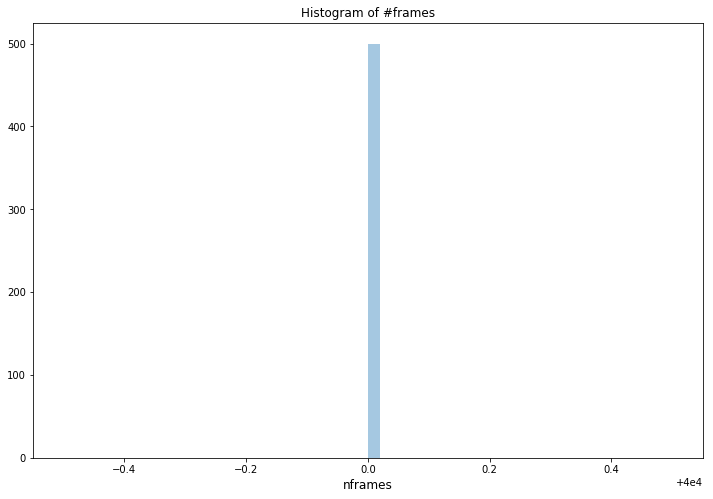

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(samples.nframes.values, bins=50, kde=False)
plt.xlabel('nframes', fontsize=12)
plt.title("Histogram of #frames")
plt.show()

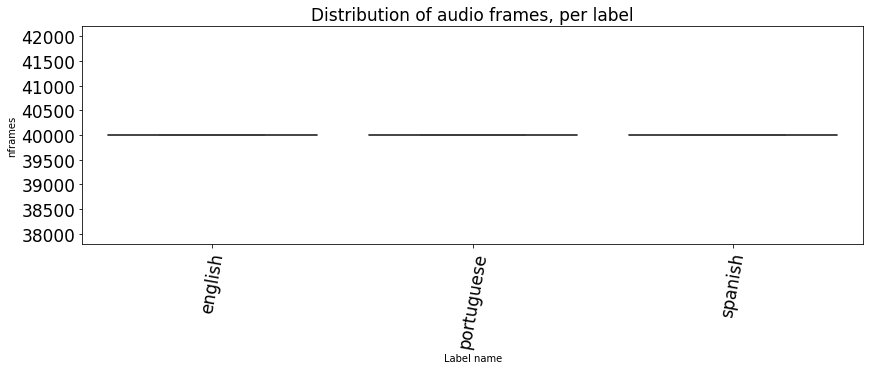

In [12]:
plt.figure(figsize=(14,4))
boxplot = sns.boxplot(x="label", y="nframes", data=samples)
boxplot.set(xlabel='', ylabel='')
plt.title('Distribution of audio frames, per label', fontsize=17)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Label name')
plt.ylabel('nframes')
plt.show()

In [13]:
temp = data.sort_values(by='label')
temp.head()

file_path    label  \
0     train/en\481-123719-0028.__trim_0_5.1__remix_\...  english   
8660  train/en\a0546__trim_0_5.1__remix_\a0546__trim...  english   
8661  train/en\211-122425-0038.__trim_0_5.1__remix_\...  english   
8662  train/en\1040-133433-0077.__trim_0_5.1__remix_...  english   
8663  train/en\3436-172171-0002.__trim_0_5.1__remix_...  english   

                     file_name speed_changing pitch_changing noise_add  \
0     481-123719-0028.__trim_0           None           None      None   
8660  a0546__trim_0_5.1__remix           None           None      None   
8661  211-122425-0038.__trim_0           None           None      None   
8662  1040-133433-0077.__trim_           None           None      None   
8663  3436-172171-0002.__trim_           None           None      None   

     low_pass  augmented_data  
0        None           False  
8660     None           False  
8661     None           False  
8662     None           False  
8663     None           False

In [14]:
def get_index_label(label):
    for i, ins in enumerate(temp['label']):
        if ins == label:
            return i
get_index_label('english')

0

Total number of labels in training data :  3
Labels are :  ['english' 'portuguese' 'spanish']


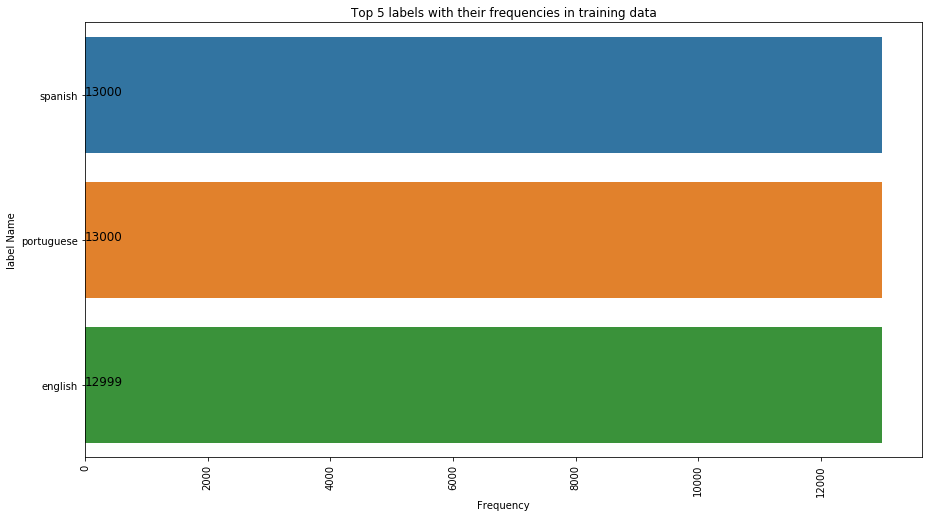

In [15]:
print("Total number of labels in training data : ",len(data['label'].value_counts()))
print("Labels are : ", data['label'].unique())
plt.figure(figsize=(15,8))
audio_type = data['label'].value_counts().head(5)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('label Name')
plt.title("Top 5 labels with their frequencies in training data")
plt.show()

In [16]:
data['gender'] = data['file_name'].apply(lambda n: n.split('_')[1])

## Instâncias por idioma

In [17]:
temp = data['label'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by language')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por quantidade de frames (amostras)

In [18]:
temp = samples['nframes'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por sample rate (amostras)

In [19]:
temp = samples['sample_rate'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por duração total (amostras)

In [20]:
def duration(nframes, sample_rate):
    return sample_rate / nframes

In [21]:
samples['duration'] = pandas.DataFrame([duration(sr, b) for sr, b
                                        in zip(samples['sample_rate'], 
                                               samples['nframes'])])
temp = samples['duration'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by duration')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por _data augmentation_

In [22]:
temp = data['augmented_data'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Data Augmentation')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por idioma e _data augmentation_

count
label      augmented_data       
english    False            8999
           True             4000
portuguese False            9000
           True             4000
spanish    False            9000
           True             4000

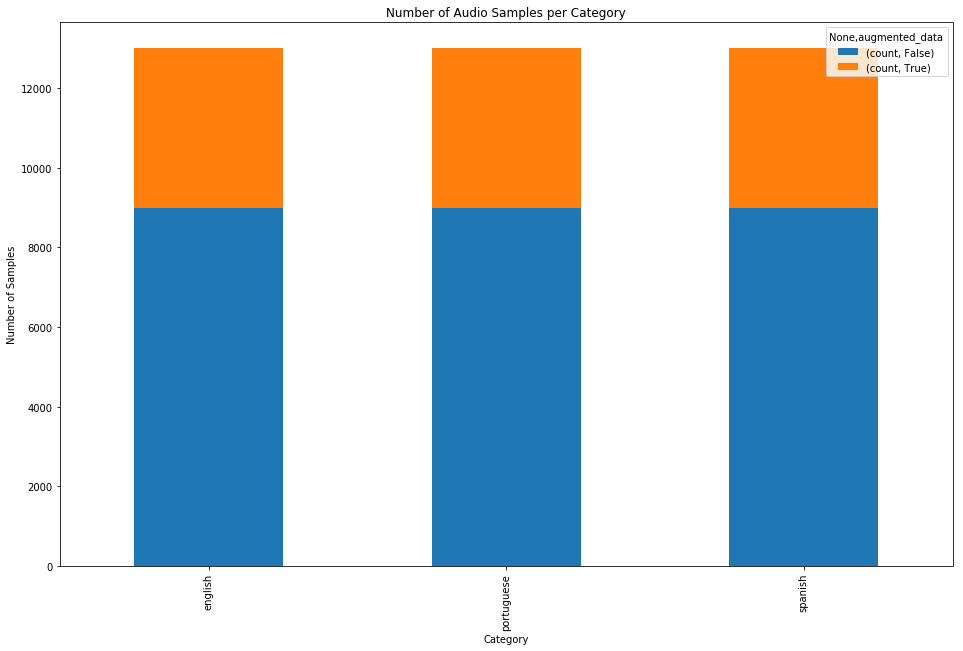

In [23]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['augmented_data']), 
                        columns=['count', 'label', 'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

count  speed_changing  pitch_changing  noise_add  \
label      augmented_data                                                     
english    False            8999               0               0          0   
           True             4000            4000               0          0   
portuguese False            9000               0               0          0   
           True             4000            4000               0          0   
spanish    False            9000               0               0          0   

                           low_pass  
label      augmented_data            
english    False                  0  
           True                   0  
portuguese False                  0  
           True                   0  
spanish    False                  0

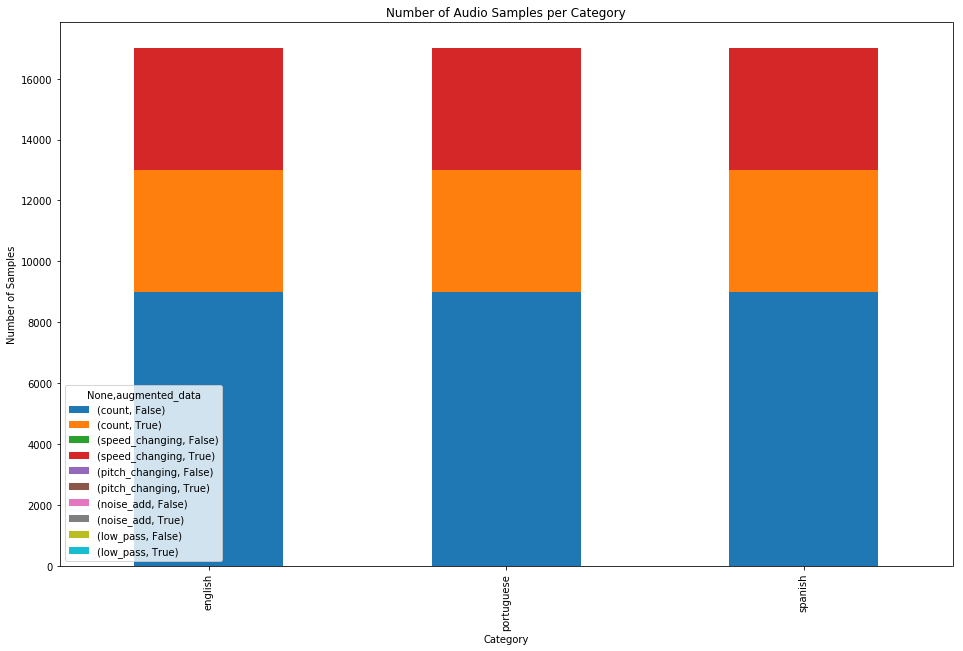

In [24]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['speed_changing'],
                            data['pitch_changing'], data['noise_add'], data['low_pass'], data['augmented_data']), 
                        columns=['count', 'label', 'speed_changing', 'pitch_changing', 'noise_add', 'low_pass',
                                'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
#category_group = category_group[category_group.speed_changing != 0]
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group.head()

## Waveform 

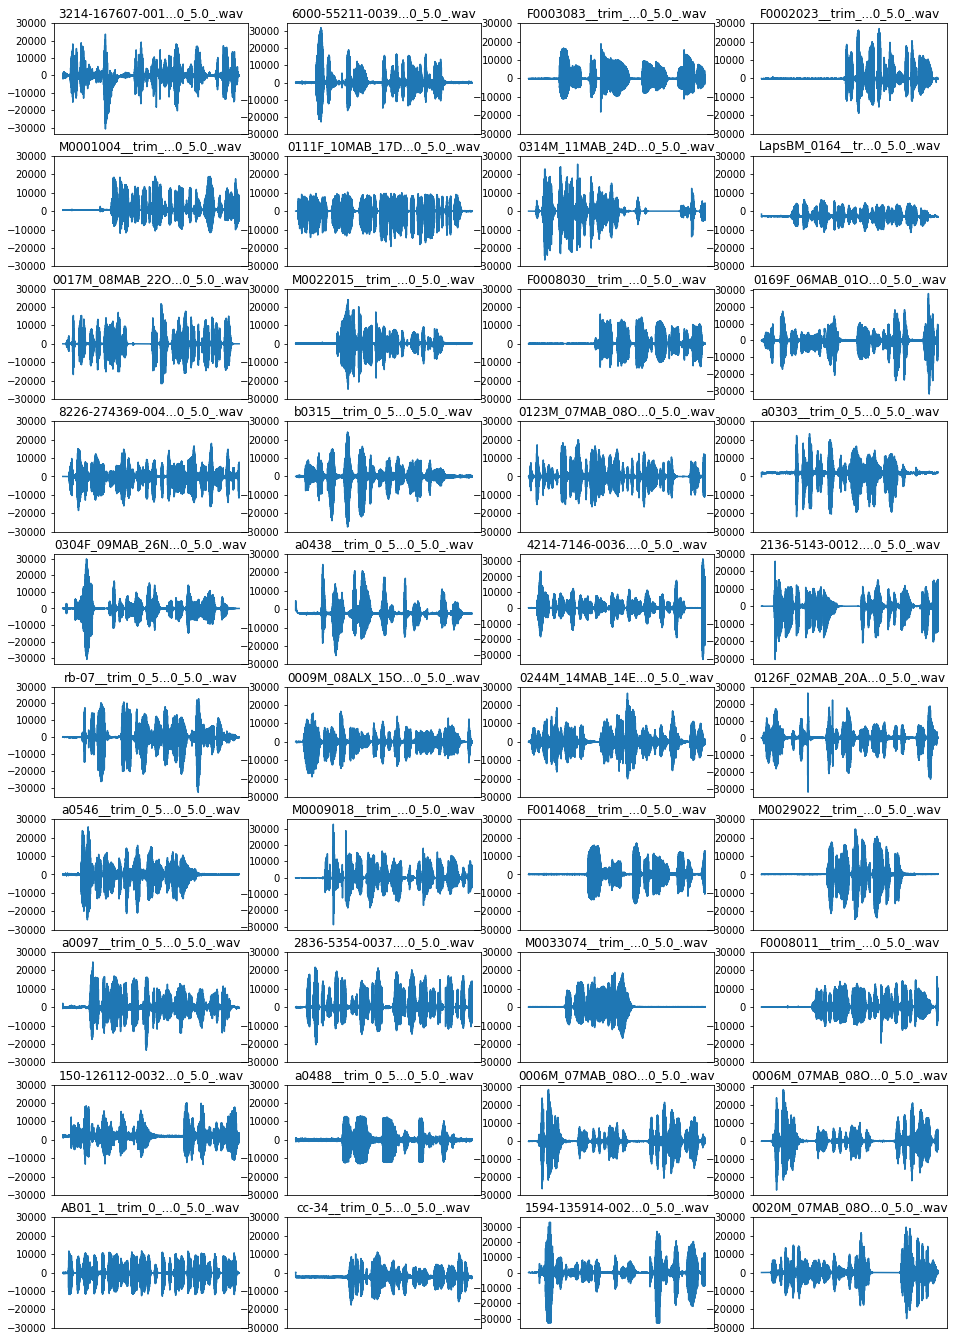

In [25]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    ax[i//4, i%4].plot(samples['time_series'][idx])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
    ax[i//4, i%4].get_yaxis().set_ticks([-30000, -20000, -10000, 0, 10000, 20000, 30000])
fig.savefig("AudioWaveform-{}-{}".format(DATASET, GROUP), dpi=900) 

## Spectrogram

In [26]:
sr, b = wavfile.read(data['file_path'][0])

In [27]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

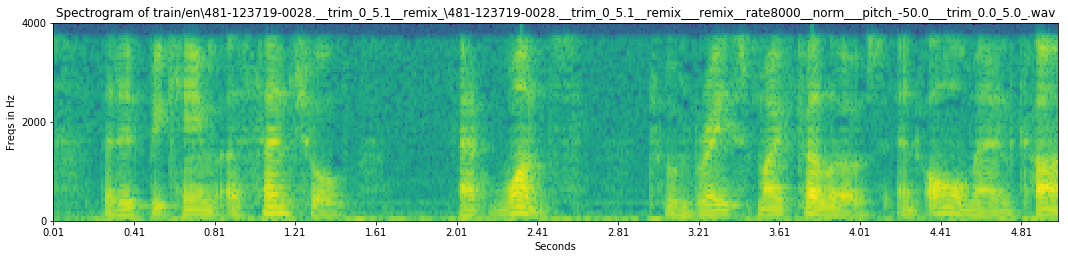

In [28]:
freqs, times, spectrogram = log_specgram(b, sr)

fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
ax2.set_xticks(times[::40])
ax2.set_title('Spectrogram of ' + data['file_path'][0])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [29]:
print("Size of training data", data.shape)

Size of training data (38999, 9)


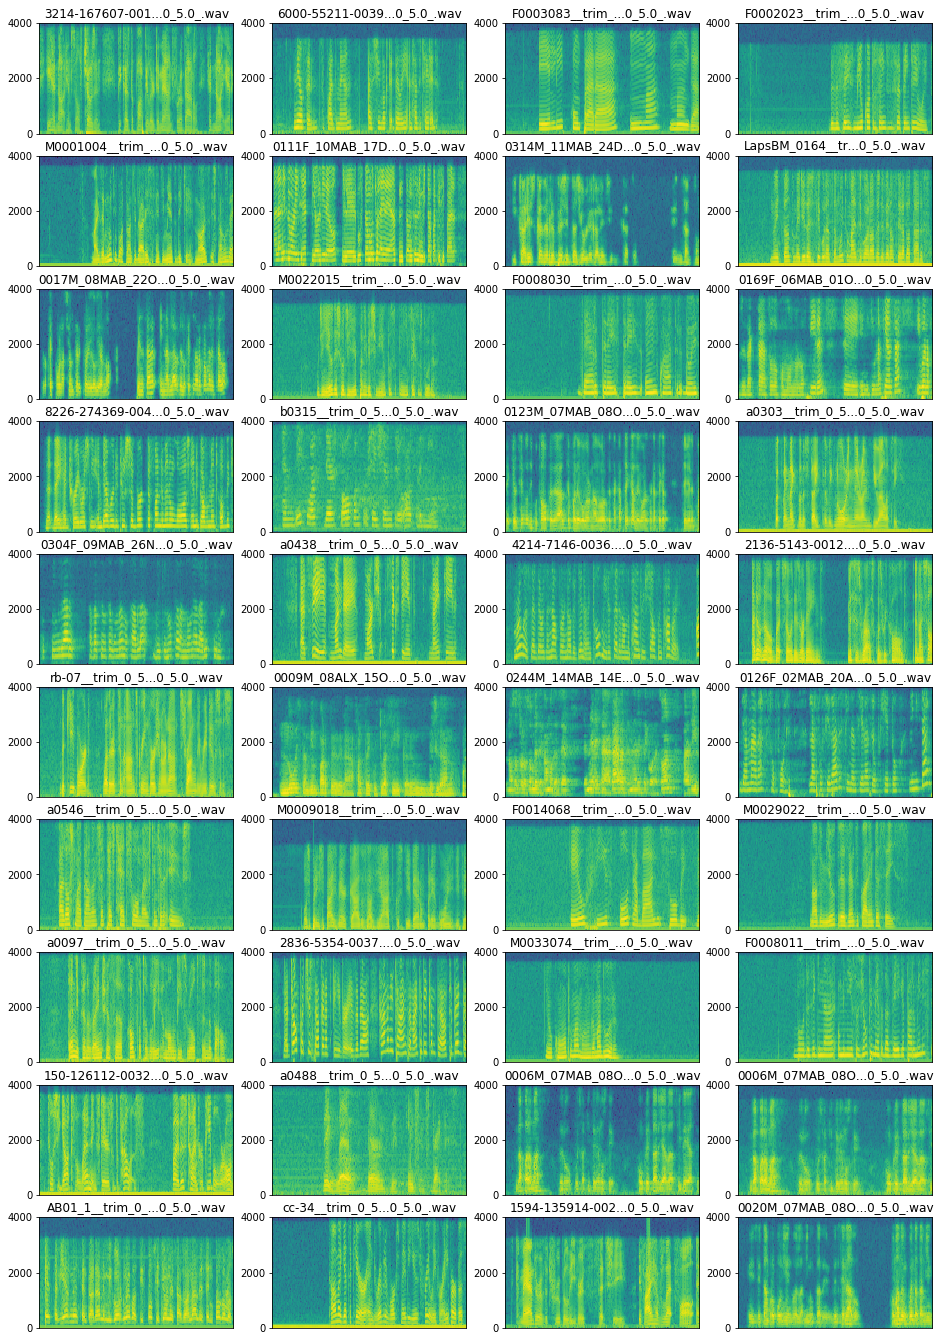

In [30]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = log_specgram(samples['time_series'][idx], sr)
    ax[i//4, i%4].imshow(spectrogram.T, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::40])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioSpectrograms-{}-{}".format(DATASET, GROUP), dpi=900) 

## MFCC

In [31]:
def mfcc_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc

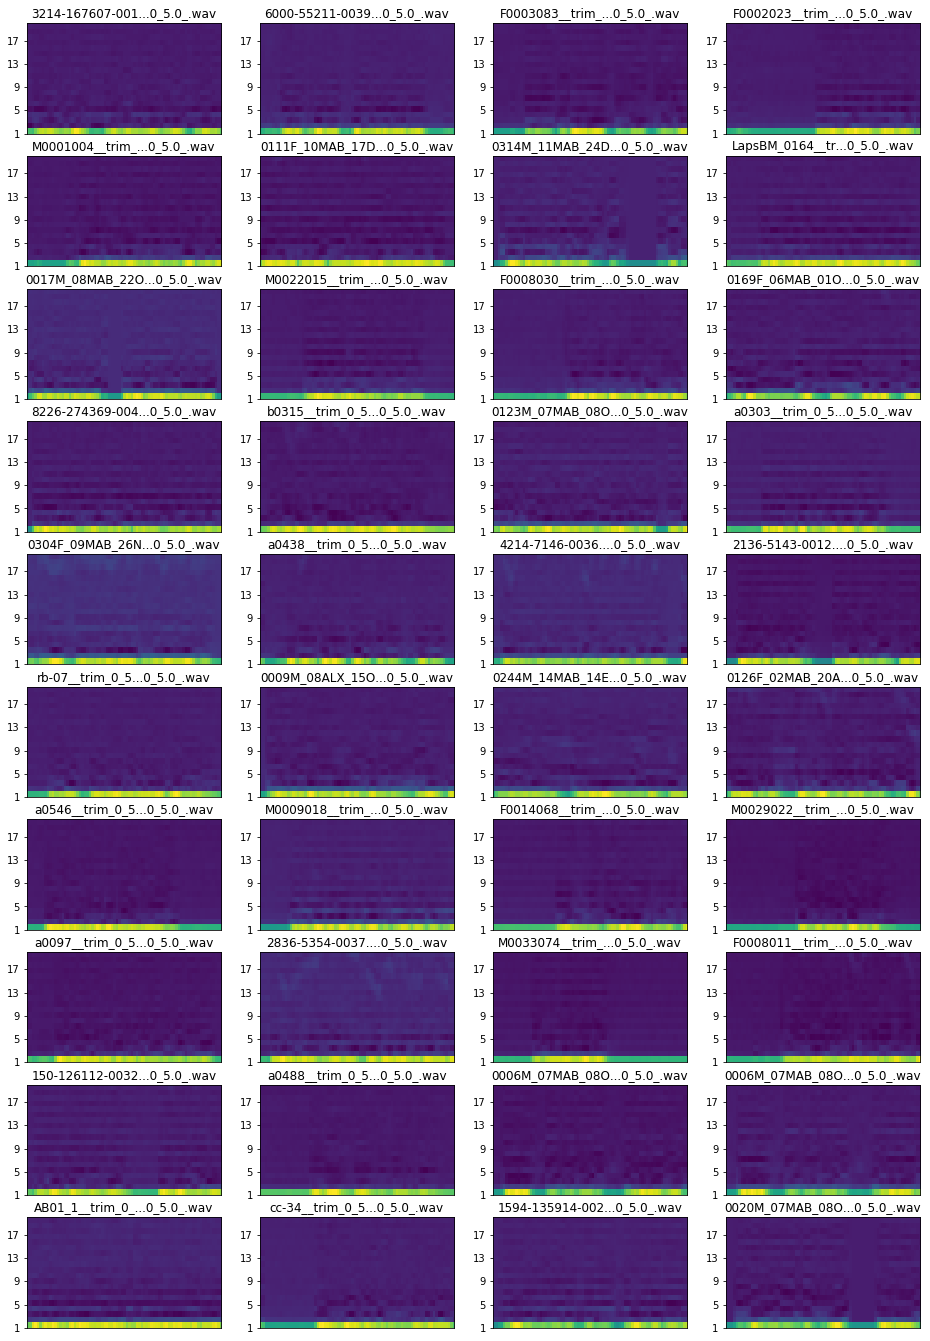

In [32]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_specgram(samples['time_series'][idx], sr,
                                              samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMFCCs-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta

In [33]:
def mfcc_delta_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

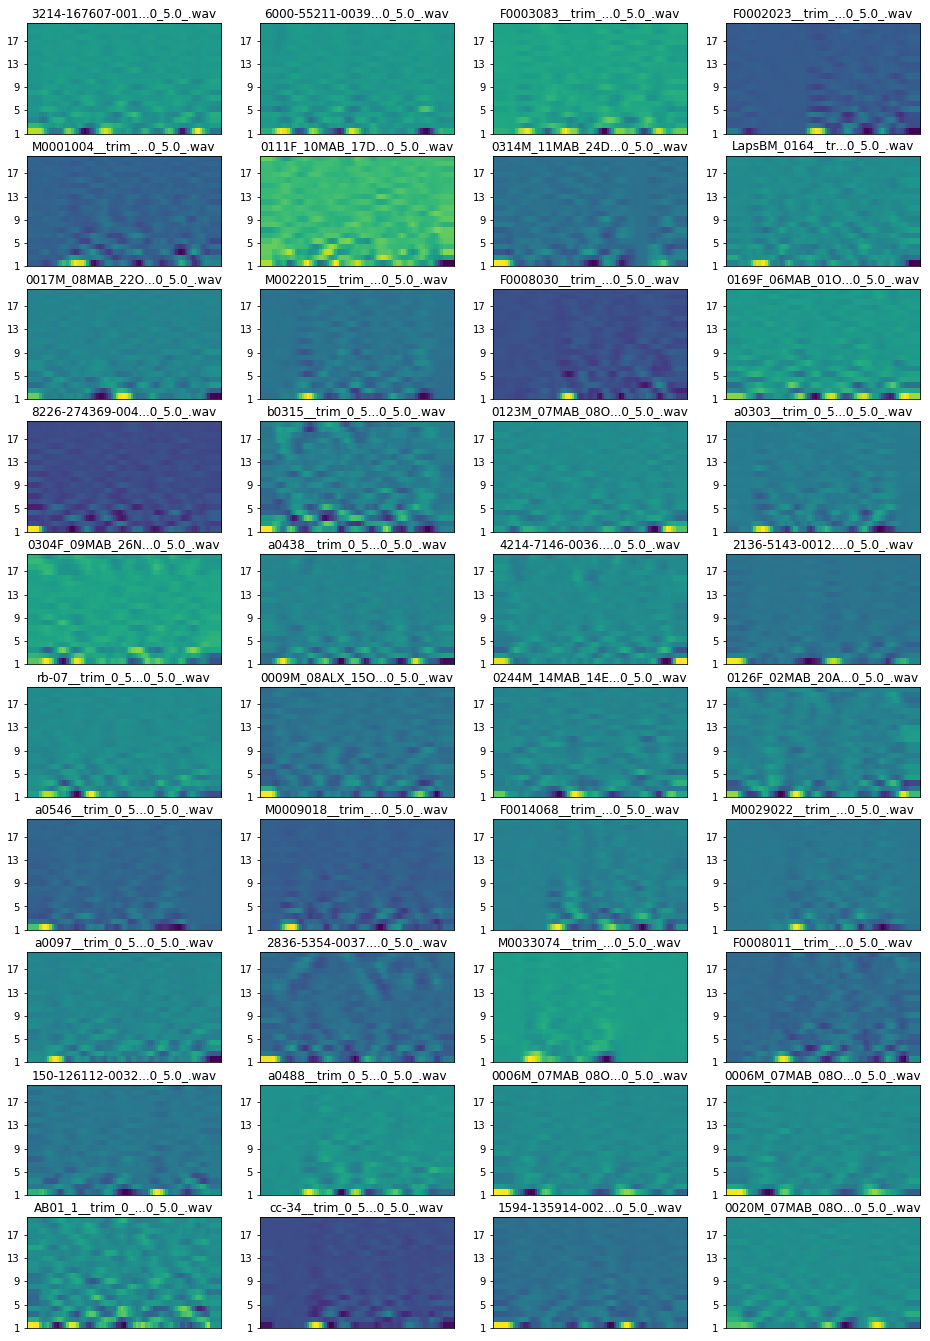

In [34]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_delta_specgram(samples['time_series'][idx], sr,
                                                    samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta Deltas

In [35]:
def mfcc_dd_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc, order=2)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

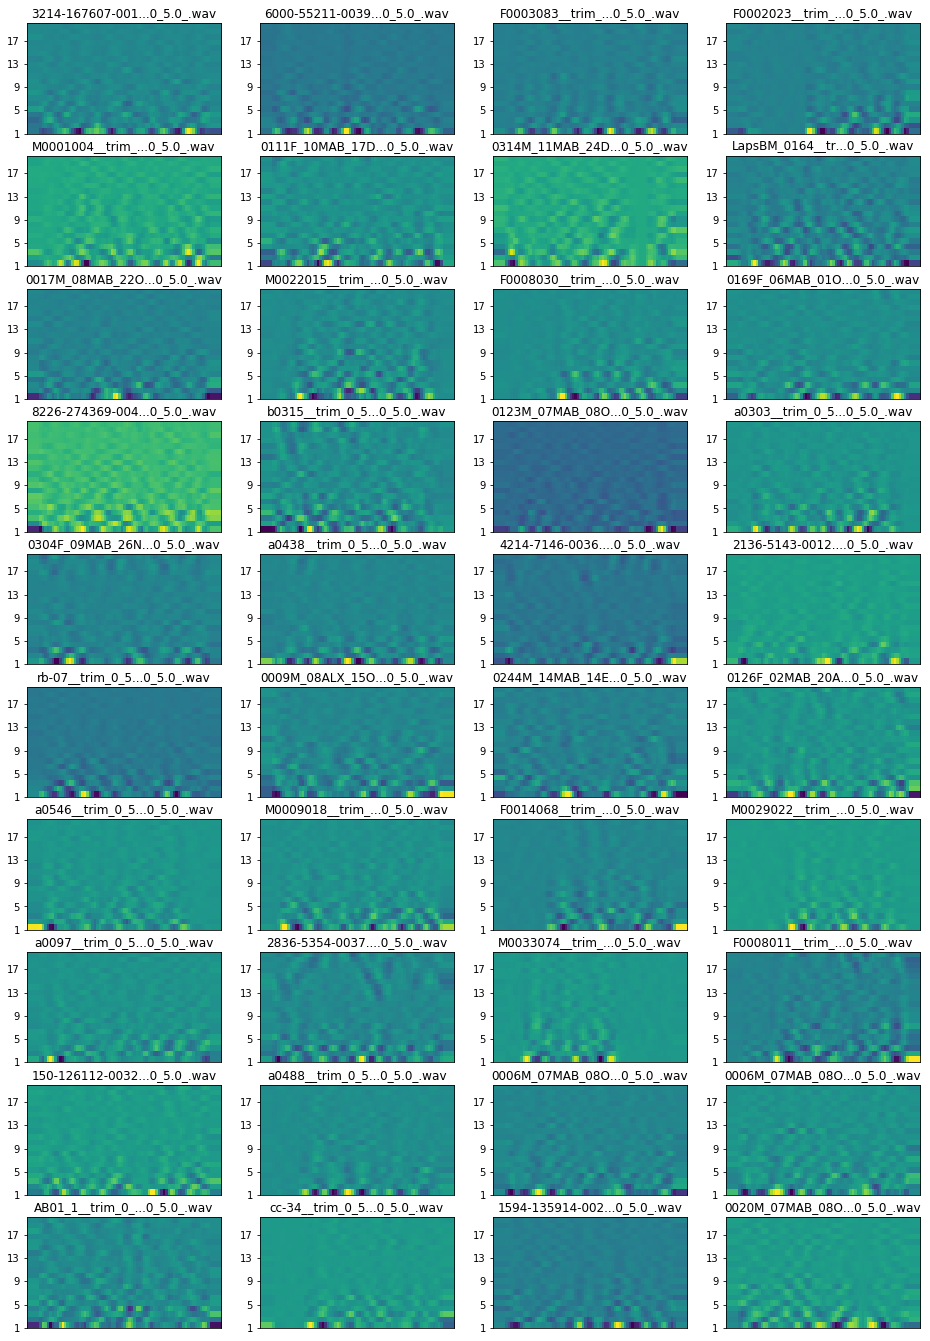

In [36]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_dd_specgram(samples['time_series'][idx], sr,
                                                 samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltaDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

## Mel Spectrogram

In [37]:
def mel_specgram(audio, sample_rate, nframes):
    spec = librosa.feature.melspectrogram(np.asarray(audio, dtype='Float64'), 
                                          sample_rate)
    times = np.linspace(0, nframes/sample_rate, spec.shape[0])
    freqs = np.linspace(1, spec.shape[1], spec.shape[1])
    return freqs, times, spec

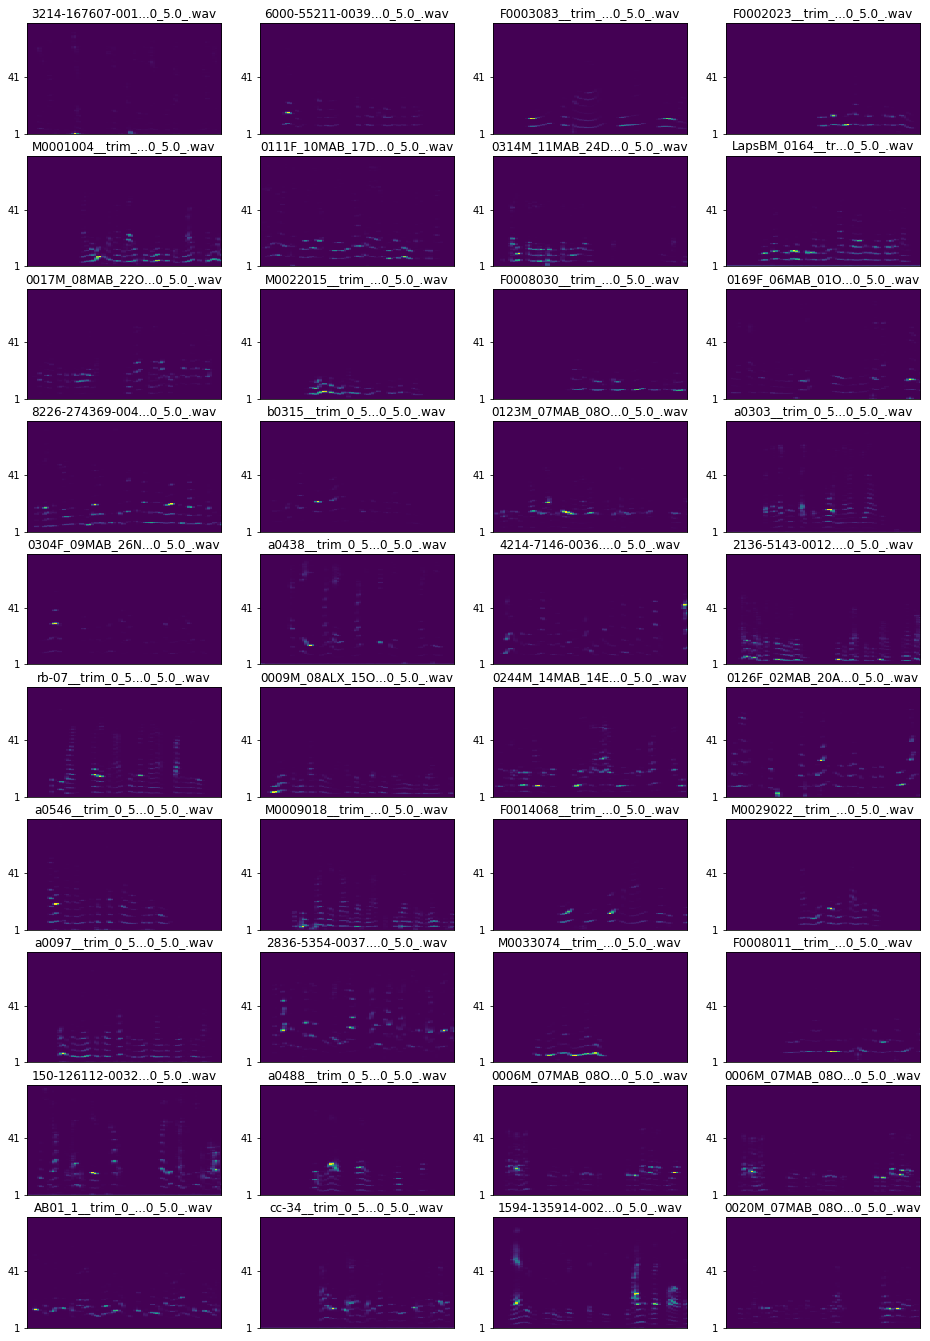

In [38]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mel_specgram(samples['time_series'][idx], sr,
                                             samples['nframes'][idx])
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMelSpecs-{}-{}".format(DATASET, GROUP), dpi=900)  